# CODE: Code for Optimizing Docking Enrichments

In [1]:
#Importa los paquetes necesarios
%pylab inline

import csv, os, random, sys, shutil
from emcee_code import emcee_code_function, modelo
from optparse import OptionParser
from __future__ import division
from scipy import stats
import numpy
numpy.set_printoptions(threshold=numpy.nan)

tamano=14

Populating the interactive namespace from numpy and matplotlib


In [2]:
inputfile='Input.csv' 
Nombre='test'
numParam=3

numTrainMol=105
semilla=1
thresAct=1 #Por debajo (o igual) a este valor se considera el compuesto activo
coluAct=2
coluMIC=3

pesot=5
thresComp=25
descrp=0
ndxchg=0

#########################################################################################################################

if os.path.exists(Nombre)==True:
    sys.exit("There is already a job with the same name. Please change it. I will not override it to then see you mad at me.")
if os.path.exists(Nombre)==False:
    os.mkdir(Nombre)

mayomen=[]

for i in range(0, numParam):
    mayomen.append(-1)
#mayomen=[-1,-1,-1,-1,-1,-1] #-1 si entre menor mejor y 1 si entre mayor mejor

shutil.copy(inputfile, Nombre)
os.rename(Nombre+'/'+inputfile, Nombre+'/'+Nombre+'_In.csv' )
#ResultsDatabase=genfromtxt(inputfile, delimiter=',')
Datos=genfromtxt(Nombre + '/'+Nombre+'_In.csv', delimiter=',', skip_header=1) 

In [3]:
def arreglar(array):
    
    ignorar=len(array[0,:])-numParam-1
    
#Normaliza valores de las columnas    
    for j in range (0, numParam):
        norm=0
        colu=ignorar+j
        minimo=min(array[:,colu])
        maximo=max(array[:,colu])
        
        if mayomen[j]==-1:
            for k in range(0, len(array[:,colu])):
                array[k,colu]=array[k,colu]-maximo
            norm=min(array[:,colu])
            for l in range(0, len(array[:,colu])):
                array[l,colu]=array[l,colu]/norm
                
        if mayomen[j]==1:
            for m in range(0, len(array[:, colu])):
                array[m, colu]=array[m,colu]-minimo
            norm=max(array[:,colu])
            for n in range(0, len(array[:,colu])):
                array[n, colu]=array[n, colu]/norm 
    
#Asigna valor boolean a coluAct    
    for o in range(0,len(array[:,0])):
        if (array[o, coluMIC]<=thresAct):
            array[o,coluAct]=1
        if (array[o, coluMIC]>thresAct):
            array[o,coluAct]=2
    return array

In [4]:
#Arregla input
DatosArreg=arreglar(Datos)

#Asigna ciertas filas al training set
filasTrain=[]
TrainSet=zeros((numTrainMol, len(DatosArreg[0,:])))

for i in range(len(DatosArreg[0,:])):
    random.seed(semilla)
    filasTrain=random.sample(range(len(DatosArreg[:,0])), numTrainMol)
    
ndx=0
for j in range(0, len(DatosArreg[:,0])):
    if ((j in filasTrain)==True):
        TrainSet[ndx,:]=DatosArreg[j,:]
        ndx+=1 

#Asigna ciertas filas al test set
filasTest=[]
TestSet=zeros((len(Datos[:,0])-numTrainMol,len(Datos[0,:])))

for i in range(0, len(DatosArreg[:,0])):
    if ((i in filasTrain)==False):
        filasTest.append(i)
        
ndx=0
for k in range(0, len(DatosArreg[:,0])):
    if ((k in filasTest)==True):
        TestSet[ndx,:]=DatosArreg[k,:]
        ndx += 1

#Crea matriz con las propiedades a usar
matriz_propiedades_train = TrainSet[:,len(TrainSet[0,:])-1-numParam:(len(TrainSet[0,:])-1)]
matriz_propiedades_test = TestSet[:,len(TestSet[0,:])-1-numParam:(len(TestSet[0,:])-1)]
matriz_propiedades = DatosArreg[:,len(DatosArreg[0,:])-1-numParam:(len(DatosArreg[0,:])-1)]

#Crea arreglo con solo datos de actividad experimental
mic_train = TrainSet[:,coluMIC]  
mic_test = TestSet[:,coluMIC]  

## MonteCarlo

Mean acceptance fraction: 0.609 (Should be between 0.25 and 0.5 approximately)
Parameter = [16 50 84]
('param1 = ', array([ 5.64467135,  6.38933769,  9.87946847]))
('param2 = ', array([ 4.11847918,  5.36096514,  6.41010576]))
('param3 = ', array([-6.48739302, -2.81505953, -1.91712979]))


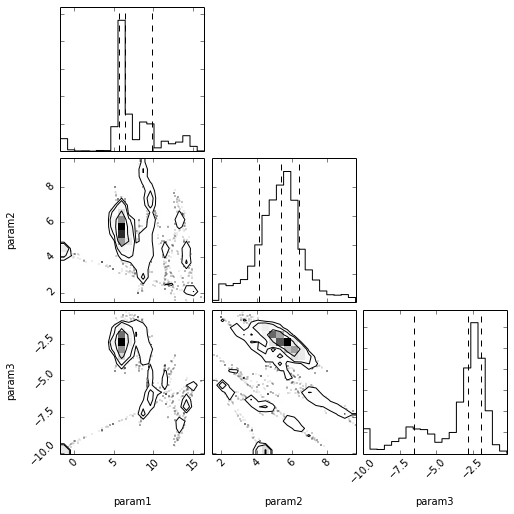

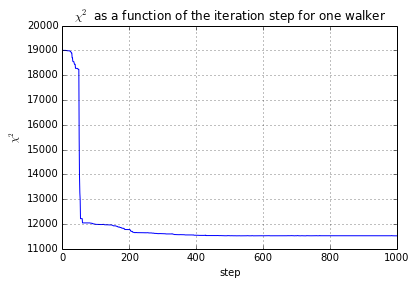

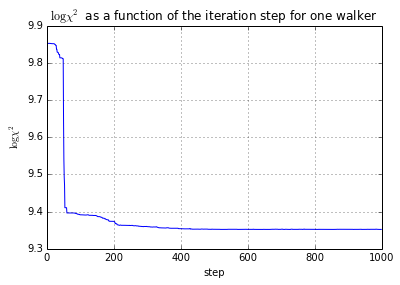

In [5]:
parametros_emcee = emcee_code_function(matriz_propiedades_train, mic_train, semilla, Nombre)
parametros_sin_error = parametros_emcee[:,1]

## Graficas y regresiones

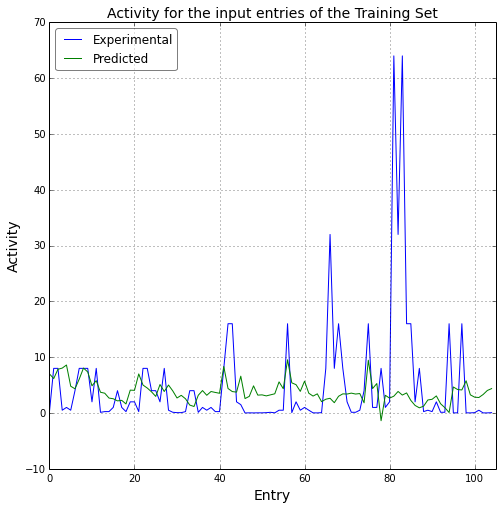

In [6]:
#Grafica la actividad predicha y experimental del Training Set en funcion de la entrada
figure(figsize=(8,8)); hold=True
plot(mic_train, label='Experimental')
plot(modelo(matriz_propiedades_train, parametros_sin_error), label='Predicted')
legend(fancybox=True, loc=2).get_frame().set_alpha(0.5)
title('Activity for the input entries of the Training Set', fontsize=tamano)
xlabel('Entry', fontsize=tamano)
ylabel('Activity', fontsize=tamano)
xlim(0,len(filasTrain))
grid()
savefig(Nombre + '/ActTrainSet.png')

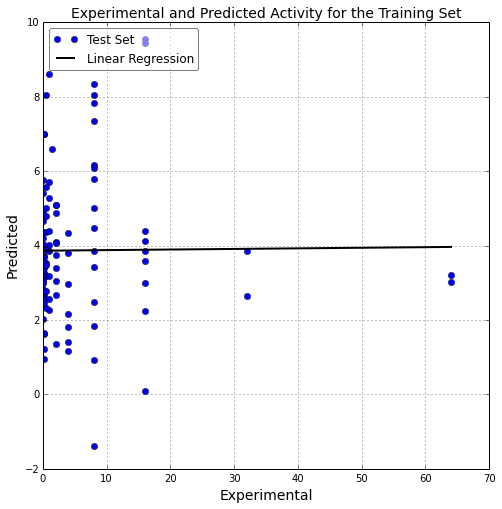

In [29]:
regre_train = stats.linregress(mic_train, modelo(matriz_propiedades_train, parametros_sin_error))
p_train=arange(min(mic_train), max(mic_train), 0.01)
lin_train=p*regre_train[0]+ regre_train[1]
#Grafica la actividad predicha y experimental del Training Set
figure(figsize=(8,8)); hold=True
plot(mic_train, modelo(matriz_propiedades_train, parametros_sin_error), 'bo', label='Test Set')
plot(p_train, lin_train, 'k-', label='Linear Regression', lw=2)
legend(fancybox=True, loc=2).get_frame().set_alpha(0.5)
title('Experimental and Predicted Activity for the Training Set', fontsize=tamano)
xlabel('Experimental', fontsize=tamano)
ylabel('Predicted', fontsize=tamano)
grid()
savefig(Nombre + '/ActTrainSetPredExp.png')

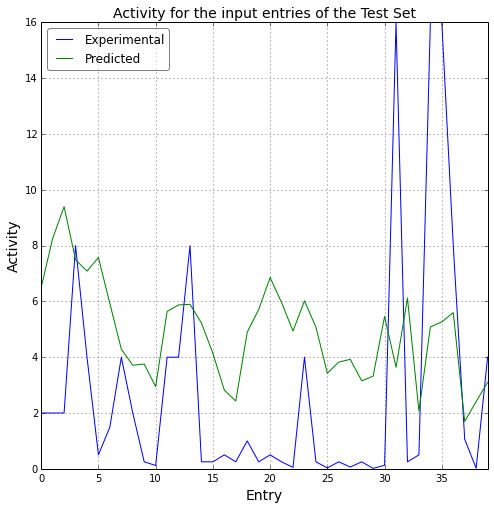

In [22]:
#Grafica la actividad predicha y experimental del Test Set en funcion de la entrada
figure(figsize=(8,8)); hold=True
plot(mic_test, label='Experimental')
plot(modelo(matriz_propiedades_test, parametros_sin_error), label='Predicted')
legend(fancybox=True, loc=2).get_frame().set_alpha(0.5)
title('Activity for the input entries of the Test Set', fontsize=tamano)
xlabel('Entry', fontsize=tamano)
ylabel('Activity', fontsize=tamano)
xlim(0,len(filasTest)-1)
grid()
savefig(Nombre + '/ActTestSet.png')

1599 6400


ValueError: x and y must have same first dimension

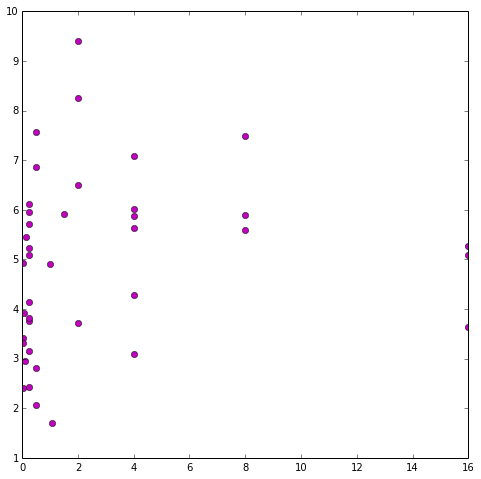

In [33]:
regre_test = stats.linregress(mic_test, modelo(matriz_propiedades_test, parametros_sin_error))
p_test=arange(min(mic_test), max(mic_test), 0.01)
lin_test=p_test*regre_test[0]+ regre_test[1]
print len(p_test), len(lin_test)
#Grafica la actividad predicha y experimental del Test Set
figure(figsize=(8,8)); hold=True
plot(mic_test, modelo(matriz_propiedades_test, parametros_sin_error), 'mo', label='Test Set')
plot(p_test, lin_test, 'k-', label='Linear Regression', lw=2)
legend(fancybox=True, loc=2).get_frame().set_alpha(0.5)
title('Experimental and Predicted Activity for the Test Set', fontsize=tamano)
xlabel('Experimental', fontsize=tamano)
ylabel('Predicted', fontsize=tamano)
grid()
savefig(Nombre + '/ActTestSetPredExp.png')

## Enriquecimiento

In [10]:
#Agrega el valor de CODE un array
def CODEfunc(array, params):
    for i in range(0, len(array[:,0])):
        for j in range(0, len(params)):
            array[i,len(array[0,:])-1]+=params[j]*array[i,len(array[0,:])-1-len(params)+j]
    return array

#Ordena el array de menor a mayor segun los valores de numcol
def Ordenador(array, numcol):
    
    Ordered=array[array[:,numcol].argsort()]
    
    return Ordered

In [11]:
#Define un nuevo array con la columna de code
DatosArreg_code = CODEfunc(DatosArreg, parametros_sin_error)

In [12]:
#Crea array con la cantidad de compuestos screened en cada slot
def CompScreened(arrayinp):
    
    compuestos_totales=len(arrayinp[:,0])
    compuestos_screened=1
    porcentaje_screened=zeros(compuestos_totales+1)
    porcentaje_screened[0]=0
    
    for i in range(compuestos_totales):
        nuevo_procentaje=(compuestos_screened/compuestos_totales)*100
        compuestos_screened +=1
        porcentaje_screened[i+1]=nuevo_procentaje
        
    return porcentaje_screened

#Crea array con la cantidad de compuestos encontrados hasta cada slot
def ActScreened(array, numcol):
    
    arrayord=Ordenador(array, numcol)
    acttot=0
    actfound=0
    actscreen=zeros(len(array[:,0])+1)
    actscreen[0]=0
    
    for h in range(0, len(arrayord[:,0])):
        if (arrayord[h,coluAct] == 1): #Aca se busca el 1 en la columna 'actcol'
            acttot += 1
            
    for i in range(0, len(arrayord[:,0])):
        if (arrayord[i, coluAct] == 1):
            actfound += 1
        actpercent = actfound/acttot * 100
        actscreen[i+1]=actpercent
        
    return actscreen

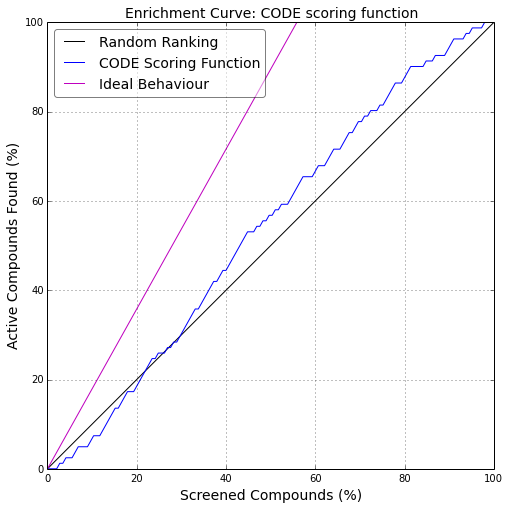

In [13]:
#Grafica curva de enriquecimiento ordenando según valores de CODE
figure(figsize=(8,8)); hold=True
p=arange(0,101,1)
lin=p
plot(p,lin, 'k-', lw=1, label=r'Random Ranking')
plot(CompScreened(DatosArreg_code), ActScreened(CODEfunc(DatosArreg_code, parametros_sin_error), len(DatosArreg_code[0,:])-1), 'b-', lw=1, label=r'CODE Scoring Function')
plot(CompScreened(DatosArreg_code), ActScreened(CODEfunc(DatosArreg_code, parametros_sin_error), coluAct), 'm-', lw=1, label=r'Ideal Behaviour')
title(r'Enrichment Curve: CODE scoring function', fontsize=tamano)
xlabel(r'Screened Compounds (%)', fontsize=tamano)
ylabel(r'Active Compounds Found (%)', fontsize=tamano)
legend(fontsize=tamano, fancybox=True, loc=2).get_frame().set_alpha(0.5)
grid()
savefig(Nombre + '/' + 'EnrichmentCurveCODE.pdf')
show()